In [0]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
nomi = pgeocode.Nominatim('IN')
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score

In [22]:
pip install pgeocode

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

In [24]:
path = ('/content/drive/My Drive/Capstone/Final_invoice.csv')
invoice = pd.read_csv(path)
invoice.head()

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total Amt Wtd Tax.,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2
3,3,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,0.00,0.0,0.0,0.0,0.0,0.00,BC01SA2
4,4,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NaN,NO,0.0,MH04CD9768,0.0,0.0,0.0,0.0,NaN,0.0,DAYANAND,2747.12,0.0,0.0,0.0,0.0,2747.12,BC01SA2


In [25]:
invoice.shape

(492314, 59)

In [0]:
invoice_missing=pd.DataFrame(invoice.isnull().sum()/invoice.shape[0]*100,columns=["Missing"])

#### Drop columns containing more than 60% missing values

In [0]:
invoice.drop(list(invoice_missing[invoice_missing["Missing"]>60].index),1,inplace=True)

In [28]:
invoice.shape

(492314, 52)

In [29]:
pd.set_option('display.max_columns', None)
invoice.drop(["Unnamed: 0"],1,inplace=True)
invoice.shape

(492314, 51)

In [0]:
remove_cols=list(invoice_missing[(invoice_missing["Missing"]>39) & (invoice_missing["Missing"]<90)].index)

In [0]:
remove_cols.remove("ODN No.")
remove_cols.remove('Outstanding Amt')
remove_cols.remove('Technician Name')
remove_cols.remove('Total Value')

In [32]:
invoice.drop(remove_cols,1,inplace=True)
invoice.shape

(492314, 32)

In [33]:
invoice.head()

,Area / Locality,CITY,Cust Type,Customer No.,District,Gate Pass Time,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Amt Wtd Tax.,Total Value,User ID
0,MAJIWADA,Thane,Retail,67849,Maharashtra,00:00:00,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,4051.95,BC01FS1
1,THNAE,THNAE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,1001.29,BC01SA2
2,THANE,THANE[W],Retail,81055,Maharashtra,00:00:00,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,233.14,BC01SA2
3,THNAE,THNAE,Retail,84419,Maharashtra,00:00:00,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,0.00,BC01SA2
4,THANE,THANE,Retail,18980,Maharashtra,00:00:00,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,2747.12,BC01SA2


#### Convert "Invoice Date" and "Inovoice Time" to datetime format, similarly for "JobCard TIme" and "JobCard Date"

In [0]:
invoice["Invoice_DateTime"]=pd.to_datetime(invoice["Invoice Date"]+" "+invoice["Invoice Time"])
invoice["JobCard_DateTime"]=pd.to_datetime(invoice["JobCard Date"]+" "+invoice["JobCard Time"])

#### Drop columns which are already combined 

In [0]:
invoice.drop(["Invoice Date","Invoice Time","JobCard Date","JobCard Time"],1,inplace=True)

#### Calculate Service Time based on JobCard Datetime and Invoice Datetime

In [0]:
invoice["Service_Time"]=invoice["Invoice_DateTime"]-invoice["JobCard_DateTime"]

#### Drop unnecessary columns

In [0]:
invoice.drop(["Labour Total","Misc Total","OSL Total","Parts Total","Total Amt Wtd Tax."],1,inplace=True)

In [38]:
invoice.shape

(492314, 26)

#### Cleaning "Area/Locality", "City" and "District" columns 

Since there are Cities,States and Areas with unclear name,We used the Geopy Nominatim Api to extract the correct names using the pincodes given in our dataset.

In [0]:
invoice["Clean_CITY"]=nomi.query_postal_code(np.array(invoice["Pin code"].astype(str))).county_name
invoice["Clean_District"]=nomi.query_postal_code(np.array(invoice["Pin code"].astype(str))).state_name
invoice["Clean_Location_Area"]=nomi.query_postal_code(np.array(invoice["Pin code"].astype(str))).place_name

#### Dropping old  "Area/Locality", "City" and "District" columns 

In [0]:
invoice.drop(["Area / Locality","CITY","District"],1,inplace=True)

In [0]:
invoice.drop(["Outstanding Amt"],1,inplace=True)

In [0]:
invoice["Year"]=invoice["Invoice_DateTime"].dt.year

In [43]:
invoice.shape

(492314, 26)

#### Calculation of Life Time Value for each customer over a period of 2013-2015 (3 years) based on "Make" and "Model" of the cars for only "Running Repairs"

In [0]:
invoice_13_15=invoice[invoice["Year"].isin([2013,2014,2015])]

In [45]:
invoice_13_15.shape

(276393, 26)

In [0]:
invoice_13_15["Service_Time_Hours"]=invoice_13_15["Service_Time"]/np.timedelta64(1, 'h')

In [47]:
invoice_13_15.head()

,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Make,Model,ODN No.,Order Type,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Year,Service_Time_Hours
0,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane Bazar, Thane H.O, Thane R.S.",2015,477.014722
1,Retail,84419,00:00:00,7005200003,173997,78584,TATA MOTORS,INDICA,7.005200e+09,SMC Value Package,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,1001.29,BC01SA2,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,Thane,Maharashtra,"Thane East, Kopri Colony",2015,19.920556
2,Retail,81055,00:00:00,7005200004,173889,33985,MARUTI SUZUKI,ZEN,7.005200e+09,Running Repairs,400607,BC01,THANE,NO,0.0,AP09AX0582,IMRAN,233.14,BC01SA2,2015-01-03 11:12:57,2015-01-02 11:40:44,0 days 23:32:13,Thane,Maharashtra,"Chitalsar Manpada, Sandozbaugh",2015,23.536944
3,Retail,84419,00:00:00,7005200005,174158,78584,TATA MOTORS,INDICA,7.005200e+09,SMC Redemption,400603,BC01,THANE,NO,0.0,MH43R3046,PRASHANT,0.00,BC01SA2,2015-01-03 11:40:44,2015-01-03 10:12:32,0 days 01:28:12,Thane,Maharashtra,"Thane East, Kopri Colony",2015,1.470000
4,Retail,18980,00:00:00,7005200006,173860,50057,HYUNDAI,SANTRO XING,7.005200e+09,Paid Service,400603,BC01,THANE,NO,0.0,MH04CD9768,DAYANAND,2747.12,BC01SA2,2015-01-03 12:07:17,2015-01-02 10:45:42,1 days 01:21:35,Thane,Maharashtra,"Thane East, Kopri Colony",2015,25.359722


We have calculated the Lifetime Value of a customer based on the Running Repairs of cutomers by total number of invoices generated multiplied by the mean of the total values spent at each service.
Also calculated the average service time taken each visit.

In [48]:
invoice_running=invoice_13_15[invoice_13_15["Order Type"]=="Running Repairs"]
invoice_running.head()

customer_freq=invoice_running.groupby(["Make","Model","Clean_Location_Area","Customer No."]).agg({"Invoice No":'count',"Total Value":'mean',"Service_Time_Hours":'mean'})
customer_freq=customer_freq.reset_index()
customer_freq.head()
ltv_make_model_r=customer_freq.copy()

ltv_make_model_r["LTV (for Running Repairs)"]=ltv_make_model_r["Invoice No"]*ltv_make_model_r["Total Value"]
ltv_make_model_r.head()

,Make,Model,Clean_Location_Area,Customer No.,Invoice No,Total Value,Service_Time_Hours,LTV (for Running Repairs)
0,AUDI,A4,"Anandibazar, Ahmednagar City, Ahmednagar H.O, ...",118262,1,1754.44,0.268056,1754.44
1,AUDI,A4,"Block 5,Neyveli, Block 26,Neyveli, Block 18,Ne...",121383,1,900.00,17.531111,900.00
2,AUDI,A4,Chander Nagar,58055,1,5700.48,26.655278,5700.48
3,AUDI,A4,"Dapodi, Dapodi Bazar",11604,1,299.04,1.235278,299.04
4,AUDI,A4,Electronics City,113926,1,21834.92,28.306389,21834.92


In [49]:
ltv_make_model_r.shape

(87496, 8)

In [50]:
ltv_make_model_r["LTV (for Running Repairs)"].describe()

count     87496.000000
mean       4299.899055
std       10325.711523
min           0.000000
25%         315.060000
50%        1083.690000
75%        4209.352500
max      732727.590000
Name: LTV (for Running Repairs), dtype: float64

In [51]:
print(ltv_make_model_r[ltv_make_model_r["LTV (for Running Repairs)"]<=1083.690000].shape)
print(ltv_make_model_r[(ltv_make_model_r["LTV (for Running Repairs)"]>1083.690000)&(ltv_make_model_r["LTV (for Running Repairs)"]<=4299.899055)].shape)
print(ltv_make_model_r[ltv_make_model_r["LTV (for Running Repairs)"]>4299.899055].shape)

(43748, 8)
(22199, 8)
(21549, 8)


In [0]:
bins=[-1,1083.690000,4299.899055,732727.60]
labels=["Low","Medium","High"]
ltv_make_model_r["LTV Binned"]=pd.cut(ltv_make_model_r["LTV (for Running Repairs)"], bins=bins, labels=labels)

In [53]:
ltv_make_model_r["LTV Binned"].value_counts()

Low       43748
Medium    22199
High      21549
Name: LTV Binned, dtype: int64

In [0]:
ltv_make_model_r.dropna(inplace=True)

In [0]:
temp_ltv_make_model_r=ltv_make_model_r.copy()

In [0]:
le=LabelEncoder()
temp_ltv_make_model_r["Make"]=le.fit_transform(temp_ltv_make_model_r["Make"])
temp_ltv_make_model_r["Model"]=le.fit_transform(temp_ltv_make_model_r["Model"])
temp_ltv_make_model_r["LTV Binned"]=le.fit_transform(temp_ltv_make_model_r["LTV Binned"])
temp_ltv_make_model_r["Clean_Location_Area"]=le.fit_transform(temp_ltv_make_model_r["Clean_Location_Area"])

In [57]:
temp_ltv_make_model_r.head()

,Make,Model,Clean_Location_Area,Customer No.,Invoice No,Total Value,Service_Time_Hours,LTV (for Running Repairs),LTV Binned
0,0,8,111,118262,1,1754.44,0.268056,1754.44,2
1,0,8,350,121383,1,900.00,17.531111,900.00,1
2,0,8,415,58055,1,5700.48,26.655278,5700.48,0
3,0,8,547,11604,1,299.04,1.235278,299.04,1
4,0,8,666,113926,1,21834.92,28.306389,21834.92,0


In [0]:
X=temp_ltv_make_model_r.drop(["Customer No.","LTV (for Running Repairs)","LTV Binned","Invoice No"],1)
y=temp_ltv_make_model_r["LTV Binned"]

In [59]:
list(X)

['Make', 'Model', 'Clean_Location_Area', 'Total Value', 'Service_Time_Hours']

In [0]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

In [0]:
rfc=RandomForestClassifier(criterion='entropy',random_state=0)

In [62]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
y_pred_rfc=rfc.predict(X_test)

In [64]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      6428
           1       0.92      0.99      0.95     13144
           2       0.80      0.77      0.78      6677

    accuracy                           0.89     26249
   macro avg       0.88      0.86      0.87     26249
weighted avg       0.89      0.89      0.89     26249



In [65]:
accuracy_score(y_test,y_pred_rfc)

0.8889862470951274

<BarContainer object of 5 artists>

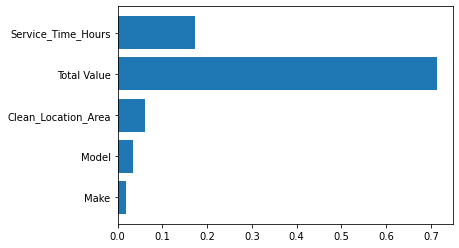

In [66]:
plt.barh(list(X),list(rfc.feature_importances_))

In [0]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [68]:
score.mean()

0.830940277730156

In [0]:
xgb=XGBClassifier()

In [70]:
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred_xgb=xgb.predict(X_test)

In [72]:
accuracy_score(y_test,y_pred_xgb)

0.8921863690045335

In [73]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      6428
           1       0.91      1.00      0.95     13144
           2       0.78      0.81      0.80      6677

    accuracy                           0.89     26249
   macro avg       0.89      0.86      0.87     26249
weighted avg       0.90      0.89      0.89     26249



In [0]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)

In [75]:
scores_xgb.mean()

0.8448266653604696

CLUSTERING

In [78]:
invoice.head(1)

,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Make,Model,ODN No.,Order Type,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Year
0,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane Bazar, Thane H.O, Thane R.S.",2015


In [0]:
df=invoice_13_15.copy()

In [86]:
df.head(1)

,Cust Type,Customer No.,Gate Pass Time,Invoice No,Job Card No,KMs Reading,Make,Model,ODN No.,Order Type,Pin code,Plant,Plant Name1,Print Status,Recovrbl Exp,Regn No,Technician Name,Total Value,User ID,Invoice_DateTime,JobCard_DateTime,Service_Time,Clean_CITY,Clean_District,Clean_Location_Area,Year,Service_Time_Hours
0,Retail,67849,00:00:00,7005200002,168303,49317,GENERAL MOTORS,SPARK,7.005200e+09,Paid Service,400601,BC01,THANE,NO,0.0,KA19MA1291,RUPESH,4051.95,BC01FS1,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,Thane,Maharashtra,"Thane Bazar, Thane H.O, Thane R.S.",2015,477.014722


In [0]:
#### Selecting columns required for clustering

cluster_df = df[['Cust Type','Customer No.','Make','Model','Order Type','Clean_CITY','Clean_Location_Area','Invoice No','Service_Time_Hours','Total Value']]

In [88]:
cluster_df.head(2)

,Cust Type,Customer No.,Make,Model,Order Type,Clean_CITY,Clean_Location_Area,Invoice No,Service_Time_Hours,Total Value
0,Retail,67849,GENERAL MOTORS,SPARK,Paid Service,Thane,"Thane Bazar, Thane H.O, Thane R.S.",7005200002,477.014722,4051.95
1,Retail,84419,TATA MOTORS,INDICA,SMC Value Package,Thane,"Thane East, Kopri Colony",7005200003,19.920556,1001.29


In [89]:
cluster_df.isnull().sum()

Cust Type                  0
Customer No.               0
Make                       0
Model                   1422
Order Type                 0
Clean_CITY             29393
Clean_Location_Area    29393
Invoice No                 0
Service_Time_Hours         0
Total Value                0
dtype: int64

In [0]:
cluster_df = cluster_df[cluster_df['Model'].notnull()]
cluster_df = cluster_df[cluster_df['Clean_CITY'].notnull()]
cluster_df = cluster_df[cluster_df['Clean_Location_Area'].notnull()]

In [92]:
cluster_df.isnull().sum()

Cust Type              0
Customer No.           0
Make                   0
Model                  0
Order Type             0
Clean_CITY             0
Clean_Location_Area    0
Invoice No             0
Service_Time_Hours     0
Total Value            0
dtype: int64

In [93]:
cluster_df.shape

(245698, 10)


Selecting columns required for clustering

In [0]:
clusters = cluster_df.groupby(['Customer No.','Cust Type','Make','Model','Clean_CITY','Order Type']).agg(
                                {
                                 'Invoice No':'nunique',
                                 'Total Value':'sum',
                                 'Service_Time_Hours':'mean'
                                }
) 

In [97]:
clusters.head()

Invoice No  \
Customer No. Cust Type Make           Model  Clean_CITY Order Type                    
1            Retail    MARUTI SUZUKI  OMNI   Pune       Running Repairs           1   
10           Retail    GENERAL MOTORS OPTRA  Mumbai     Paid Service              2   
1000         Retail    MARUTI SUZUKI  ALTO   Pune       Paid Service              2   
                                                        Running Repairs           2   
10000        Retail    MARUTI SUZUKI  WAGONR Hyderabad  Running Repairs           4   

                                                                         Total Value  \
Customer No. Cust Type Make           Model  Clean_CITY Order Type                     
1            Retail    MARUTI SUZUKI  OMNI   Pune       Running Repairs         0.00   
10           Retail    GENERAL MOTORS OPTRA  Mumbai     Paid Service         4943.67   
1000         Retail    MARUTI SUZUKI  ALTO   Pune       Paid Service         4799.70   
                                                        Running Repairs      1196.17   
10000        Retail    MARUTI SUZUKI  WAGONR Hyderabad  Running Repairs       734.23   

                                                                         Service_Time_Hours  
Customer No. Cust Type Make           Model  Clean_CITY Order Type                           
1            Retail    MARUTI SUZUKI  OMNI   Pune       Running Repairs          321.365833  
10           Retail    GENERAL MOTORS OPTRA  Mumbai     Paid Service               5.496667  
1000         Retail    MARUTI SUZUKI  ALTO   Pune       Paid Service               5.378056  
                                                        Running Repairs            5.319444  
10000        Retail    MARUTI SUZUKI  WAGONR Hyderabad  Running Repairs           10.841042

In [98]:
clusters.columns

Index(['Invoice No', 'Total Value', 'Service_Time_Hours'], dtype='object')

In [0]:
clusters.columns =['Total Invoices','Total Revenue','Total Servicing Hrs']

In [0]:
clusters = clusters.reset_index()

In [103]:
clusters.shape

(171533, 9)


Separating customers with zero revenue

In [0]:
zero_spenders = clusters[clusters['Total Revenue']<=0]

In [104]:
zero_spenders.shape

(16273, 9)

In [0]:
zero_spenders['Clusters'] = 'zero_spenders'

In [106]:
zero_spenders.head(2)

,Customer No.,Cust Type,Make,Model,Clean_CITY,Order Type,Total Invoices,Total Revenue,Total Servicing Hrs,Clusters
0,1,Retail,MARUTI SUZUKI,OMNI,Pune,Running Repairs,1,0.0,321.365833,zero_spenders
5,10000,Retail,MARUTI SUZUKI,WAGONR,Hyderabad,SMC Redemption,2,0.0,1.629167,zero_spenders


Separating customers with non zero spends

In [0]:
non_zero = clusters[clusters['Total Revenue']>0]

In [108]:
non_zero.shape

(155260, 9)

In [111]:
print("0.05 quantile :",non_zero['Total Revenue'].quantile(0.05))
print("0.25 quantile :",non_zero['Total Revenue'].quantile(0.25))
print("0.50 quantile :",non_zero['Total Revenue'].quantile(0.50))
print("0.75 quantile :",non_zero['Total Revenue'].quantile(0.75))
print("0.95 quantile :",non_zero['Total Revenue'].quantile(0.95))
print("minimum total revenue :",non_zero['Total Revenue'].min())
print("maximum total revenue :",non_zero['Total Revenue'].max())
print("mean total revenue :",non_zero['Total Revenue'].mean())

0.05 quantile : 199.14
0.25 quantile : 855.32
0.50 quantile : 2911.665
0.75 quantile : 7284.715
0.95 quantile : 25835.69799999999
minimum total revenue : 0.85
maximum total revenue : 1627429.4600000002
mean total revenue : 6994.111150199257


In [112]:
print("0.05 quantile :",non_zero['Total Servicing Hrs'].quantile(0.05))
print("0.25 quantile :",non_zero['Total Servicing Hrs'].quantile(0.25))
print("0.50 quantile :",non_zero['Total Servicing Hrs'].quantile(0.50))
print("0.75 quantile :",non_zero['Total Servicing Hrs'].quantile(0.75))
print("0.95 quantile :",non_zero['Total Servicing Hrs'].quantile(0.95))
print("mimimum servicing time in hrs :",non_zero['Total Servicing Hrs'].min())
print("maximum servicing time in hrs :",non_zero['Total Servicing Hrs'].max())
print("mean servicing time in hrs :",non_zero['Total Servicing Hrs'].mean())

0.05 quantile : 0.2858194444444446
0.25 quantile : 3.8802777777777777
0.50 quantile : 19.537847222222222
0.75 quantile : 55.95333333333333
0.95 quantile : 294.3995833333328
mimimum servicing time in hrs : 0.010833333333333334
maximum servicing time in hrs : 13392.034444444444
mean servicing time in hrs : 72.89619913536694


Rule Based Clustering based on avg revenue

In [0]:
# Low revenue customers (less than 0.50 quantile)
low_revenue = non_zero[(non_zero['Total Revenue']< non_zero['Total Revenue'].quantile(0.50))]

# Medium revenue customers (between 0.50 to 0.75 quantile)
medium_revenue = non_zero[
                            (non_zero['Total Revenue'] > non_zero['Total Revenue'].quantile(0.50)) & 
                            (non_zero['Total Revenue']< non_zero['Total Revenue'].quantile(0.75))
                         ]

# Average revenue customers (between 0.75 to 0.95 quantile)
avg_revenue = non_zero[
                        (non_zero['Total Revenue'] > non_zero['Total Revenue'].quantile(0.75)) & 
                        (non_zero['Total Revenue'] < non_zero['Total Revenue'].quantile(0.95))
                      ]

# High revenue customers (moe than 0.95 quantile)
high_revenue = non_zero[
                        (non_zero['Total Revenue'] > non_zero['Total Revenue'].quantile(0.95))
                       ]

In [114]:
print(low_revenue.shape)
print(medium_revenue.shape)
print(avg_revenue.shape)
print(high_revenue.shape)

(77630, 9)
(38815, 9)
(31052, 9)
(7763, 9)


In [0]:
# Naming the clusters
low_revenue['Clusters'] = 'low_revenue'
medium_revenue['Clusters'] = 'medium_revenue'
avg_revenue['Clusters'] = 'avg_revenue'
high_revenue['Clusters'] = 'high_revenue'

In [0]:
revenue_clust = pd.concat([low_revenue,medium_revenue,avg_revenue,high_revenue],axis=0)

In [117]:
revenue_clust.groupby(['Clusters']).agg({'Total Revenue':'mean','Total Servicing Hrs':'mean','Customer No.':'count'}).sort_values('Total Revenue',ascending=False)

,Total Revenue,Total Servicing Hrs,Customer No.
Clusters,,,
high_revenue,53238.328151,317.685001,7763
avg_revenue,13128.734642,113.997044,31052
medium_revenue,4652.884270,58.577905,38815
low_revenue,1086.453493,39.136128,77630


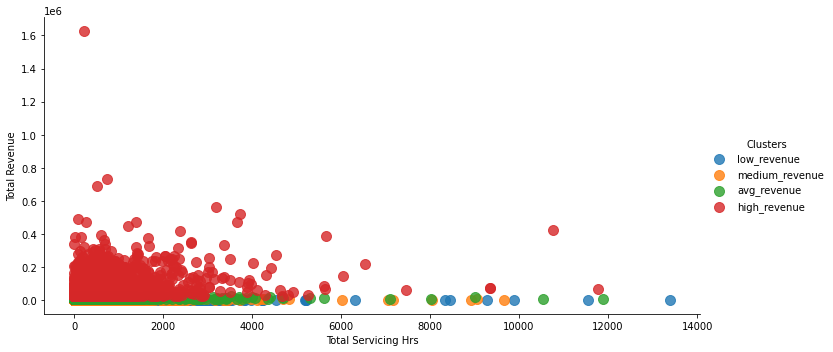

In [118]:
sns.lmplot(data=revenue_clust,x='Total Servicing Hrs', y='Total Revenue', hue='Clusters', fit_reg=False, legend=True, legend_out=True,size=5,aspect=2,scatter_kws={"s": 100})

Rule Based Clustering based on avg servicing time

In [0]:
# super fast service (less than 0.50 quantile)
super_fast = non_zero[non_zero['Total Servicing Hrs']< non_zero['Total Servicing Hrs'].quantile(0.50)]

# fast service (between 0.50 to 0.75 quantile)
fast = non_zero[
                (non_zero['Total Servicing Hrs']> non_zero['Total Servicing Hrs'].quantile(0.50)) & 
                (non_zero['Total Servicing Hrs']< non_zero['Total Servicing Hrs'].quantile(0.75))
                ]

# slow service (between 0.75 to 0.95 quantile)
slow = non_zero[
                (non_zero['Total Servicing Hrs'] > non_zero['Total Servicing Hrs'].quantile(0.75)) & 
                (non_zero['Total Servicing Hrs'] < non_zero['Total Servicing Hrs'].quantile(0.95))
                ]

# super fast service (more than 0.95 quantile)
super_slow = non_zero[
                        non_zero['Total Servicing Hrs'] > non_zero['Total Servicing Hrs'].quantile(0.95)
                     ]

In [120]:
print(super_fast.shape)
print(fast.shape)
print(slow.shape)
print(super_slow.shape)

(77630, 9)
(38815, 9)
(31052, 9)
(7763, 9)


In [0]:
super_fast['Clusters'] = 'super_fast'
fast['Clusters'] = 'fast'
slow['Clusters'] = 'slow'
super_slow['Clusters'] = 'super_slow'

In [0]:
f_clust = pd.concat([super_fast,fast,slow,super_slow],axis=0)

In [123]:

f_clust.groupby(['Clusters']).agg({'Total Revenue':'mean','Total Servicing Hrs':'mean','Customer No.':'count'}).sort_values('Total Servicing Hrs',ascending=False)

,Total Revenue,Total Servicing Hrs,Customer No.
Clusters,,,
super_slow,28916.210140,723.392761,7763
slow,12875.201412,128.709527,31052
fast,6498.558506,34.350225,38815
super_fast,2697.241469,4.794199,77630


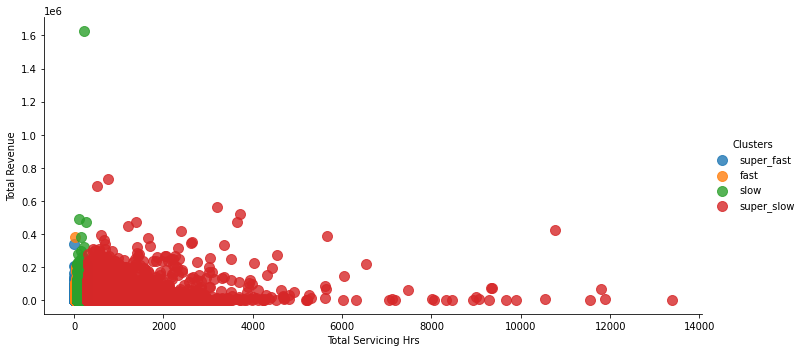

In [124]:
sns.lmplot(data=f_clust,x='Total Servicing Hrs', y='Total Revenue', hue='Clusters', fit_reg=False, legend=True, legend_out=True,size=5,aspect=2,scatter_kws={"s": 100})

K-Means Clustering

In [0]:
final_cluster = non_zero

In [126]:
final_cluster.shape

(155260, 9)

In [127]:
final_cluster.describe()

,Total Invoices,Total Revenue,Total Servicing Hrs
count,155260.000000,1.552600e+05,155260.000000
mean,1.443630,6.994111e+03,72.896199
std,1.480906,1.565903e+04,234.777198
min,1.000000,8.500000e-01,0.010833
25%,1.000000,8.553200e+02,3.880278
50%,1.000000,2.911665e+03,19.537847
75%,1.000000,7.284715e+03,55.953333
max,226.000000,1.627429e+06,13392.034444


In [128]:
final_cluster.head()

,Customer No.,Cust Type,Make,Model,Clean_CITY,Order Type,Total Invoices,Total Revenue,Total Servicing Hrs
1,10,Retail,GENERAL MOTORS,OPTRA,Mumbai,Paid Service,2,4943.67,5.496667
2,1000,Retail,MARUTI SUZUKI,ALTO,Pune,Paid Service,2,4799.70,5.378056
3,1000,Retail,MARUTI SUZUKI,ALTO,Pune,Running Repairs,2,1196.17,5.319444
4,10000,Retail,MARUTI SUZUKI,WAGONR,Hyderabad,Running Repairs,4,734.23,10.841042
6,10000,Retail,MARUTI SUZUKI,WAGONR,Hyderabad,SMC Value Package,1,1001.29,3.169444


Label Encoding Categorical Columns

In [0]:
X = final_cluster.drop(['Customer No.'],axis=1)

le=LabelEncoder()
X["Make"]=le.fit_transform(X["Make"])
X["Model"]=le.fit_transform(X["Model"])
X["Clean_CITY"]=le.fit_transform(X["Clean_CITY"])
X["Cust Type"]=le.fit_transform(X["Cust Type"])
X["Order Type"]=le.fit_transform(X["Order Type"])

In [130]:
X.head()

,Cust Type,Make,Model,Clean_CITY,Order Type,Total Invoices,Total Revenue,Total Servicing Hrs
1,5,6,130,169,1,2,4943.67,5.496667
2,5,13,16,210,1,2,4799.70,5.378056
3,5,13,16,210,3,2,1196.17,5.319444
4,5,13,206,103,3,4,734.23,10.841042
6,5,13,206,103,5,1,1001.29,3.169444


Scaling the features

In [131]:
std = StandardScaler()
X=std.fit_transform(X)

scaled_data = pd.DataFrame(X)
scaled_data.columns = ['Cust Type','Make','Model','Clean_CITY','Order Type','Total Invoices','Total Revenue','Total Servicing Hrs']
scaled_data.head()

,Cust Type,Make,Model,Clean_CITY,Order Type,Total Invoices,Total Revenue,Total Servicing Hrs
0,0.045933,-1.197916,0.163695,0.255284,-0.841542,0.375697,-0.130943,-0.287080
1,0.045933,-0.007664,-1.574291,0.776774,-0.841542,0.375697,-0.140138,-0.287585
2,0.045933,-0.007664,-1.574291,0.776774,0.664826,0.375697,-0.370263,-0.287834
3,0.045933,-0.007664,1.322352,-0.584188,0.664826,1.726226,-0.399763,-0.264316
4,0.045933,-0.007664,1.322352,-0.584188,2.171193,-0.299568,-0.382708,-0.296992


Calculating wcss score using elbow method

In [0]:
wcss=[]
for i in range(2,12):
    clf=KMeans(n_clusters=i,random_state=42,init='k-means++')
    clf.fit(X)
    wcss.append(clf.inertia_)

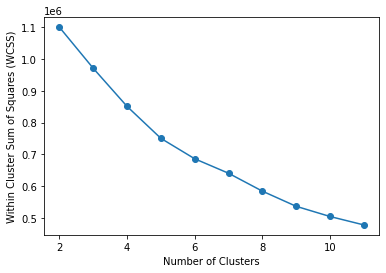

In [133]:
x=np.arange(2,12)
plt.plot(x,wcss)
plt.scatter(x,wcss)
plt.ylabel("Within Cluster Sum of Squares (WCSS)")
plt.xlabel("Number of Clusters");

In [134]:
clf_final=KMeans(n_clusters=6,random_state=42,init='k-means++')
clf_final.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
final_cluster["Clusters"]=clf_final.predict(X)

In [136]:
final_cluster.head()

,Customer No.,Cust Type,Make,Model,Clean_CITY,Order Type,Total Invoices,Total Revenue,Total Servicing Hrs,Clusters
1,10,Retail,GENERAL MOTORS,OPTRA,Mumbai,Paid Service,2,4943.67,5.496667,3
2,1000,Retail,MARUTI SUZUKI,ALTO,Pune,Paid Service,2,4799.70,5.378056,0
3,1000,Retail,MARUTI SUZUKI,ALTO,Pune,Running Repairs,2,1196.17,5.319444,0
4,10000,Retail,MARUTI SUZUKI,WAGONR,Hyderabad,Running Repairs,4,734.23,10.841042,2
6,10000,Retail,MARUTI SUZUKI,WAGONR,Hyderabad,SMC Value Package,1,1001.29,3.169444,2


In [0]:
final_cluster.to_csv('Final_Clusters.csv')

In [0]:
cluster_excel = final_cluster.groupby(["Clusters","Cust Type"]).agg({"Total Revenue":"mean","Total Servicing Hrs":'mean',"Customer No.":"count"}).sort_values('Total Revenue')

In [139]:
final_cluster.groupby(["Clusters","Order Type"]).agg({"Total Revenue":"mean","Total Servicing Hrs":'mean',"Customer No.":"count"})

Total Revenue  Total Servicing Hrs  Customer No.
Clusters Order Type                                                         
0        Accidental          10361.866083           127.736928          3163
         Paid Service         5239.196784            46.507308         16143
         Running Repairs      3840.706160            39.868872         27920
         SMC Redemption       1794.734323            46.519759           266
         SMC Value Package    3386.685723             9.608473          1564
1        Accidental          96829.319036          1009.645815          1400
         Paid Service        43747.991968          1479.723521           371
         Running Repairs     53725.294839          1385.251059           589
         SMC Redemption       2781.500000          1683.052847             2
         SMC Value Package   59931.410000          1017.001731             3
2        Repeat Order         3966.740000            22.913333             1
         Running Repairs      4724.249822            39.784450         36477
         SMC Redemption       1961.354691            51.617591           437
         SMC Value Package    3791.830477             7.169019          4776
3        Accidental          13687.056212           146.016623         11762
         Paid Service         6808.340399            52.957099         22200
4        Accidental          26168.632424           265.650044            66
         Paid Service        28699.029184           111.309013            98
         Running Repairs     26346.237248            70.769219           149
         SMC Value Package    6500.343333             9.728657             3
5        Accidental          13927.306296           140.370456          3583
         Paid Service         6158.571831            72.590320          7433
         Running Repairs      3864.339211            46.730744         15810
         SMC Redemption       1862.737288            31.720014           118
         SMC Value Package    3260.684708            13.497188           926

In [0]:
cluster_excel.columns = ['Avg revenue','Avg Servicing Hrs','Customer Count']

In [0]:
cluster_Excel = cluster_excel.reset_index()

In [142]:
cluster_excel.sort_values(by='Clusters')

Avg revenue  Avg Servicing Hrs  Customer Count
Clusters Cust Type                                                         
0        Insurance           4235.490000          48.614722               1
         Retail              4695.315658          46.780181           49032
         MFCWL               5768.480435          68.076620              23
1        Retail             77495.639513        1169.991374            2363
         Fleets            249455.695000       10060.966806               2
2        Retail              4588.217676          36.166214           41677
         MFCWL               5298.126429          52.651258              14
3        MFCWL               6032.854444          77.133719               9
         Retail              9191.471043          85.188376           33953
4        Fleets             21411.526786          97.065043             140
         Corporate others   28796.560236         124.577390             127
         Corporate- M&M     37345.879184         196.011251              49
5        Retail              5740.658218          64.475810           27859
         MFCWL               7600.505455         121.275248              11

In [0]:
cluster_excel.to_csv('cluster_representation.csv')

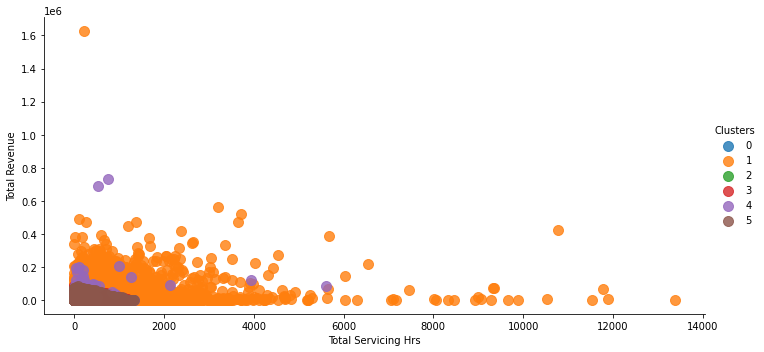

In [144]:
sns.lmplot(data=final_cluster,x='Total Servicing Hrs', y='Total Revenue', hue='Clusters', fit_reg=False, legend=True, legend_out=True,size=5,aspect=2,scatter_kws={"s": 100})